In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from xgboost import plot_tree
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, precision_recall_fscore_support
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE, SequentialFeatureSelector
import xgboost as xgb
from sklearn.feature_selection import SelectKBest, mutual_info_classif, SelectFromModel
import shap



IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
orig_df = pd.read_csv('../data/HG_FinnRisk.txt', sep="\t", decimal=',')
df = orig_df.copy(deep=True)
df

,Sample,Cohort,BL_AGE,DIAB_AGE,PREVAL_DIAB,INCIDENT_DIAB,DIAB_T2,INCIDENT_DIAB_T2,PREVAL_DIAB_T2,DIABETES,...,S0,S1,S2,S3,S4,G0,G1,G2,G3,G4
0,4002080252,FinnRisk,55.425,57.914,0,1,1,1,0,1,...,20.283231,22.250976,42.787746,12.390338,2.367405,5.591518,9.952926,65.662110,10.801767,6.913720
1,4002122536,FinnRisk,63.091,67.912,0,0,0,0,0,0,...,25.713805,20.716524,40.441785,10.990010,2.207924,12.985303,10.094260,60.134224,10.058022,5.752116
2,4004158639,FinnRisk,63.039,65.966,0,1,1,1,0,1,...,19.590076,19.764287,41.950454,15.955089,2.837085,9.428330,7.936387,58.555138,15.986374,6.992649
3,4005016134,FinnRisk,69.621,73.177,0,1,1,1,0,1,...,22.158784,22.398594,41.815866,11.325313,2.393041,8.691062,10.098506,63.139637,12.201526,4.750372
4,4005072554,FinnRisk,34.839,38.500,0,1,1,1,0,1,...,20.373851,22.320652,41.729478,12.659140,3.010846,8.142575,8.575747,63.082484,13.314909,5.914578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,8201319256,FinnRisk,72.939,74.478,0,1,1,1,0,1,...,14.620877,21.858393,46.587682,13.839056,3.208529,7.697855,5.397993,65.842189,13.630958,6.608456
70,8201319737,FinnRisk,61.993,71.718,0,0,0,0,0,0,...,24.924114,24.461817,37.979003,10.272909,2.446926,8.668266,11.347195,62.279094,11.513344,4.748123
71,8201335752,FinnRisk,46.637,56.537,0,0,0,0,0,0,...,24.907871,23.905185,38.701173,10.529598,2.033491,9.141776,10.698590,63.140974,10.934956,5.010190
72,8201344755,FinnRisk,68.912,78.111,0,1,1,1,0,1,...,23.096526,26.170355,37.417074,11.303001,2.104148,10.712715,8.556974,63.067076,10.716105,5.845915


In [3]:
# Drop redundant columns and derived traits

df = df.drop(columns=["Sample","Cohort","BL_AGE","DIAB_AGE","PREVAL_DIAB","INCIDENT_DIAB","DIAB_T2","INCIDENT_DIAB_T2","PREVAL_DIAB_T2","LB","HB","S0","S1","S2","S3","S4","G0","G1","G2","G3","G4"])
df

,DIABETES,GP1,GP2,GP3,GP4,GP5,GP6,GP7,GP8,GP9,...,GP37,GP38,GP39,GP40,GP41,GP42,GP43,GP44,GP45,GP46
0,1,0.016118,0.072337,0.002572,0.045732,3.306536,1.466415,0.056500,4.104061,2.488629,...,1.574028,3.533020,0.435101,0.498498,0.407196,0.321716,0.528683,0.311149,0.486703,0.311959
1,0,0.021173,0.153304,0.005156,0.082791,9.825144,2.218289,0.064145,4.702867,2.291542,...,1.468835,2.817054,0.352065,0.305025,0.367101,0.336453,0.517333,0.302512,0.406641,0.277884
2,1,0.029867,0.254652,0.008845,0.112243,5.682548,2.646903,0.097515,3.025506,1.620590,...,2.270035,3.237520,0.440493,0.380561,0.530053,0.509171,0.696077,0.380045,0.441853,0.279887
3,1,0.032442,0.183741,0.009748,0.108015,5.281655,2.298598,0.105786,4.164279,2.214504,...,1.470287,1.651568,0.387695,0.226472,0.405673,0.522430,0.645012,0.318333,0.279970,0.221623
4,1,0.023237,0.125931,0.005816,0.058770,4.914101,2.244814,0.049552,3.704350,1.747848,...,1.779718,2.171635,0.378182,0.259946,0.502981,0.606240,0.828614,0.384596,0.434373,0.254043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,1,0.027266,0.127565,0.006394,0.121648,5.184831,1.581612,0.062864,1.842558,1.120240,...,1.381881,2.526835,0.411248,0.347308,0.380211,0.768169,0.847621,0.479761,0.455312,0.277455
70,0,0.027380,0.300511,0.006148,0.110258,4.521746,2.783183,0.134617,4.795504,2.342855,...,1.048636,1.724066,0.304114,0.188247,0.494815,0.509339,0.476596,0.394672,0.201768,0.369735
71,0,0.023312,0.453886,0.003816,0.131517,4.407034,2.777473,0.201509,4.409247,2.514163,...,1.117534,2.420510,0.266629,0.212242,0.439485,0.340023,0.348504,0.356669,0.249731,0.299080
72,1,0.015276,0.149216,0.001344,0.149289,7.201589,2.374565,0.106164,3.415930,1.996433,...,0.701030,2.925496,0.311306,0.413861,0.309195,0.499816,0.396500,0.355059,0.305574,0.238004


In [4]:
df.columns

Index(['DIABETES', 'GP1', 'GP2', 'GP3', 'GP4', 'GP5', 'GP6', 'GP7', 'GP8',
       'GP9', 'GP10', 'GP11', 'GP12', 'GP13', 'GP14', 'GP15', 'GP16', 'GP17',
       'GP18', 'GP19', 'GP20', 'GP21', 'GP22', 'GP23', 'GP24', 'GP25', 'GP26',
       'GP27', 'GP28', 'GP29', 'GP30', 'GP31', 'GP32', 'GP33', 'GP34', 'GP35',
       'GP36', 'GP37', 'GP38', 'GP39', 'GP40', 'GP41', 'GP42', 'GP43', 'GP44',
       'GP45', 'GP46'],
      dtype='object')

In [5]:
#ALLGLYCANS
"""glycan_dict = {              
                'GP32_33':['GP32','GP33'],
                'GP38_39':['GP38','GP39'],
                'GP41_43':['GP41','GP42','GP43']
               }

df_combined = pd.DataFrame()

for key,value in glycan_dict.items():
    df_combined[key] = df[value].sum(axis=1)

df = df.join(df_combined)
df = df.drop(columns=['GP32','GP33','GP38','GP39','GP41','GP42','GP43'])
df.columns"""

"glycan_dict = {              \n                'GP32_33':['GP32','GP33'],\n                'GP38_39':['GP38','GP39'],\n                'GP41_43':['GP41','GP42','GP43']\n               }\n\ndf_combined = pd.DataFrame()\n\nfor key,value in glycan_dict.items():\n    df_combined[key] = df[value].sum(axis=1)\n\ndf = df.join(df_combined)\ndf = df.drop(columns=['GP32','GP33','GP38','GP39','GP41','GP42','GP43'])\ndf.columns"

In [6]:
# GLYCOTYPE
glycan_dict = {                 
                'LB_SO':['GP1','GP2','GP3','GP4','GP5','GP6','GP7','GP8','GP9','GP10','GP11','GP12','GP13','GP14','GP15','GP24'],
                'LB_S1':['GP16','GP17','GP18','GP19','GP20','GP21','GP22'],
                'LB_S2':['GP23','GP25','GP26','GP27','GP28'],
                'HB_S1':['GP30'],
                'HB_S2':['GP29','GP31'],
                'HB_S3':['GP32','GP33','GP34','GP35','GP36','GP37','GP38','GP39','GP40'],
                'HB_S4':['GP41','GP42','GP43','GP44','GP45','GP46'],
               }

df_combined = pd.DataFrame()

for key,value in glycan_dict.items():
    df_combined[key] = df[value].sum(axis=1)

df = df_combined.join(df['DIABETES'])
df.columns

Index(['LB_SO', 'LB_S1', 'LB_S2', 'HB_S1', 'HB_S2', 'HB_S3', 'HB_S4',
       'DIABETES'],
      dtype='object')

In [7]:
from sklearn.preprocessing import LabelEncoder

target = "DIABETES"

# The LabelEncoder
le = LabelEncoder()

# Encode categorical target in the combined data
df[target] = le.fit_transform(df[target])


In [8]:
le.classes_

array([0, 1], dtype=int64)

In [9]:
X= df.drop(columns=[target]).reset_index(drop=True)
y = np.array(df[target])

In [10]:
print('Input', X.shape)
print('Output', y.shape)

Input (74, 7)
Output (74,)


In [11]:
X.head()

,LB_SO,LB_S1,LB_S2,HB_S1,HB_S2,HB_S3,HB_S4
0,21.416539,19.401808,41.466167,0.079696,2.878048,12.390338,2.367405
1,26.766238,17.913468,39.510156,0.070048,2.542156,10.990010,2.207924
2,20.753897,16.482271,39.784809,0.096990,4.089859,15.955089,2.837085
3,23.509438,18.943104,40.595560,0.091598,3.141948,11.325313,2.393041
4,21.425581,18.569010,40.775923,0.093967,3.465532,12.659140,3.010846


In [12]:
y

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 1], dtype=int64)

In [13]:
random_seed = 42

# Divide the data into training (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.80, 
                                                    random_state=random_seed,
                                                    stratify=y)

# Reset the index
X_train, X_test = X_train.reset_index(drop=True), X_test.reset_index(drop=True)

features = X_train.columns

In [14]:
X_train.shape

(59, 7)

## All Features

In [49]:
score = 'roc_auc'

pipe = Pipeline(
    [
        #("scaling", StandardScaler()),
        ("scaling", PowerTransformer()),
        # the reduce_dim stage is populated by the param_grid
        ("reduce_dim", "passthrough"),
        ("classify", "passthrough"),
    ]
)

N_FEATURES_OPTIONS = np.arange(1, 43, 1)
C_OPTIONS = np.arange(0.01, 1, 0.05)
GAMMA_OPTIONS = [0, 0.01, 0.1, 1, 5]
KERNEL_OPTIONS = ['linear', 'poly', 'rbf', 'sigmoid']
N_NEIGHBORS_OPTIONS = np.arange(2, 20, 1)
SOLVER = ['lbfgs', 'sgd', 'adam']
HIDDEN_LAYERS = [(150,25,10,10,), (300,100,50), (150,50,), (300,200,100,), (100,), (50,50,50,)]
CRITERION_OPTIONS = ['gini', 'entropy', 'log_loss']
MIN_SAMPLES_SPLIT = [2,3,4,5]
MIN_SAMPLES_LEAF = [1,2,3,4]
MIN_CHILD_WEIGHT = [0, 0.01, 0.1, 1, 5]

param_grid = [
    {
        "reduce_dim": [RFE(LogisticRegression(class_weight='balanced', random_state=random_seed))],
        "reduce_dim__n_features_to_select": N_FEATURES_OPTIONS,
        "reduce_dim__estimator__C": C_OPTIONS,
        "classify": [LogisticRegression(class_weight='balanced', random_state=random_seed)],
        "classify__C": C_OPTIONS
    },
    {   
        "classify": [SVC(class_weight='balanced', random_state=random_seed, probability=True)],
        #"classify__C": C_OPTIONS,
        #"classify__kernel": KERNEL_OPTIONS
    },
    {
        "classify": [KNeighborsClassifier()],
        "classify__n_neighbors": N_NEIGHBORS_OPTIONS
    },
    {
        "classify": [MLPClassifier(random_state=random_seed, max_iter=2000)],
        "classify__solver": SOLVER,
        "classify__hidden_layer_sizes": HIDDEN_LAYERS
    },
    {
        "reduce_dim": [RFE(RandomForestClassifier(class_weight='balanced', random_state=random_seed))],
        #"reduce_dim": [SequentialFeatureSelector(RandomForestClassifier(class_weight='balanced', random_state=random_seed),direction="backward",tol=-0.001,scoring="roc_auc")],
        "reduce_dim__n_features_to_select": N_FEATURES_OPTIONS,
        "reduce_dim__estimator__criterion": CRITERION_OPTIONS,
        "reduce_dim__estimator__min_samples_split": MIN_SAMPLES_SPLIT,
        "reduce_dim__estimator__min_samples_leaf": MIN_SAMPLES_LEAF,
        "classify": [RandomForestClassifier(class_weight='balanced', random_state=random_seed)],
        "classify__criterion": CRITERION_OPTIONS,
        "classify__min_samples_split": MIN_SAMPLES_SPLIT,
        "classify__min_samples_leaf": MIN_SAMPLES_LEAF
    },
    {
        #"reduce_dim": [RFE(xgb.XGBClassifier())],
        #"reduce_dim__n_features_to_select": N_FEATURES_OPTIONS,
        #"reduce_dim__estimator__gamma": GAMMA_OPTIONS,
        #"reduce_dim__estimator__min_child_weight": MIN_CHILD_WEIGHT,
        "classify": [xgb.XGBClassifier()],
        "classify__gamma": GAMMA_OPTIONS,
        "classify__min_child_weight": MIN_CHILD_WEIGHT
    }
    ]

preset_grid = [
    {
        #0.7016071428571429
        "reduce_dim": [SequentialFeatureSelector(LogisticRegression(class_weight='balanced', random_state=random_seed),direction="backward",scoring="roc_auc")],
        "reduce_dim__tol": [-0.001],
        "reduce_dim__estimator__C": [0.001], 
        "classify": [LogisticRegression(class_weight='balanced', random_state=random_seed)],
        "classify__C": [0.001]
    },
    {   
        #0.7036309523809524
        "reduce_dim": [SequentialFeatureSelector(SVC(class_weight='balanced', random_state=random_seed, probability=True),direction="backward",scoring="roc_auc")],
        "reduce_dim__tol": [0.01],
        "reduce_dim__estimator__C": [0.1], 
        "reduce_dim__estimator__kernel": ['poly'], 
        "classify": [SVC(class_weight='balanced', random_state=random_seed, probability=True)],
        "classify__C": [0.1],
        "classify__kernel": ["poly"]
    },
    {
        #0.6891369047619047
        "reduce_dim": [SequentialFeatureSelector(KNeighborsClassifier(),direction="backward",scoring="roc_auc")],
        "reduce_dim__tol": [-0.01],
        "reduce_dim__estimator__n_neighbors": [19],
        "classify": [KNeighborsClassifier()],
        "classify__n_neighbors": [19]
    },
    {
        #0.6345833333333333
        "classify": [MLPClassifier(random_state=random_seed, max_iter=2000)],
        "classify__solver": ["sgd"],
        "classify__hidden_layer_sizes": [(150, 25, 10, 10)]
    },
    {
        #0.7192857142857143
        "classify": [RandomForestClassifier(class_weight='balanced', random_state=random_seed)],
        "classify__criterion": ["gini"],
        "classify__min_samples_split": [2],
        "classify__min_samples_leaf": [4]
    },
    {
        #0.7560714285714285
        "reduce_dim": [SequentialFeatureSelector(xgb.XGBClassifier(),direction="backward",scoring="roc_auc")],
        "reduce_dim__tol": [0.0001],
        "reduce_dim__estimator__gamma": [3],
        "reduce_dim__estimator__min_child_weight": [5],
        "classify": [xgb.XGBClassifier()],
        "classify__gamma": [3],
        "classify__min_child_weight": [5]
    }
]
    

grid = GridSearchCV(pipe, n_jobs=4, param_grid=preset_grid[5], cv=5, scoring=score, verbose=1, return_train_score=True)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaling', PowerTransformer()),
                                       ('reduce_dim', 'passthrough'),
                                       ('classify', 'passthrough')]),
             n_jobs=4,
             param_grid={'classify': [XGBClassifier(base_score=None,
                                                    booster=None,
                                                    callbacks=None,
                                                    colsample_bylevel=None,
                                                    colsample_bynode=None,
                                                    colsample_bytree=None,
                                                    device=None,
                                                    early_stopping_rounds=None,
                                                    enable_categorical=F...
                                                                                          max_leaves=None,
                                                                                          min_child_weight=None,
                                                                                          missing=nan,
                                                                                          monotone_constraints=None,
                                                                                          multi_strategy=None,
                                                                                          n_estimators=None,
                                                                                          n_jobs=None,
                                                                                          num_parallel_tree=None,
                                                                                          random_state=None, ...),
                                                                  scoring='roc_auc')],
                         'reduce_dim__estimator__gamma': [3],
                         'reduce_dim__estimator__min_child_weight': [5],
                         'reduce_dim__tol': [0.0001]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [50]:
print (f"Train: {grid.cv_results_['mean_train_score'][grid.cv_results_['rank_test_score'] == 1]}")
print (f"Test: {grid.cv_results_['mean_test_score'][grid.cv_results_['rank_test_score'] == 1]}")

print (grid.best_score_)
print (grid.best_params_)
print (grid.best_estimator_)

Train: [0.875212]
Test: [0.75607143]
0.7560714285714285
{'classify': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...), 'classify__gamma': 3, 'classify__min_child_weight': 5, 'reduce_dim': SequentialFeatureSelector(direction='backward',
                          estimator=XGBClassifier(base_

## Test Set Eval

Accuracy: 0.800
F1 score: 0.800
AUC: 0.812


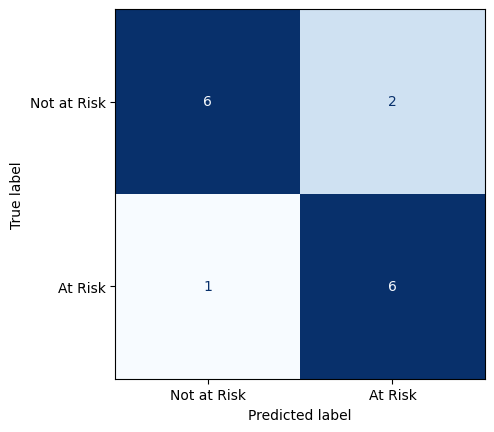

In [51]:
# Test scores
preds = grid.predict(X_test)
pred_proba = grid.predict_proba(X_test)

print (f'Accuracy: {accuracy_score(y_test, preds):.3f}')
print (f'F1 score: {f1_score(y_test, preds, average="macro"):.3f}')
print (f'AUC: {roc_auc_score(y_test, pred_proba[:,1]):.3f}')

conf_m = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay.from_predictions(y_test, preds, display_labels=["Not at Risk","At Risk"],colorbar=False, cmap=plt.cm.Blues)
plt.show()

In [52]:
print(classification_report(y_test, preds))

print (precision_recall_fscore_support(y_test, preds))

              precision    recall  f1-score   support

           0       0.86      0.75      0.80         8
           1       0.75      0.86      0.80         7

    accuracy                           0.80        15
   macro avg       0.80      0.80      0.80        15
weighted avg       0.81      0.80      0.80        15



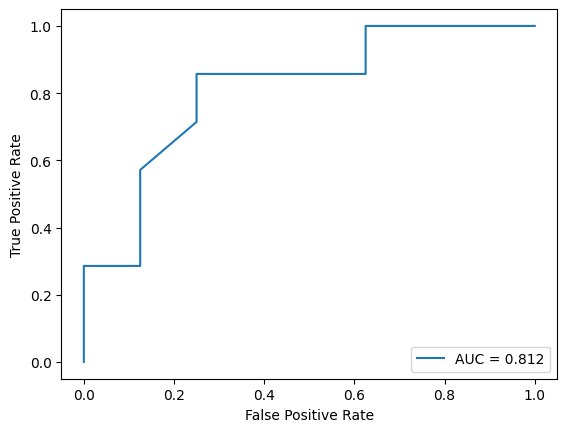

In [56]:
auc_preds = pred_proba[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  auc_preds)
auc = metrics.roc_auc_score(y_test, auc_preds)
label = f"AUC = {auc:.3f}"
plt.plot(fpr,tpr,label=label)


plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc=4)
plt.show()

## Glycotypes

In [15]:
pipe = Pipeline(
    [
        #("scaling", StandardScaler()),
        ("scaling", PowerTransformer()),
        # the reduce_dim stage is populated by the param_grid
        ("reduce_dim", "passthrough"),
        ("classify", "passthrough"),
    ]
)

N_FEATURES_OPTIONS = np.arange(1, 8, 1)
C_OPTIONS = np.arange(0.01, 1, 0.01)
GAMMA_OPTIONS = [0, 0.001, 0.1, 1, 5]
KERNEL_OPTIONS = ['linear', 'poly', 'rbf', 'sigmoid']
N_NEIGHBORS_OPTIONS = np.arange(2, 20, 1)
SOLVER = ['lbfgs', 'sgd', 'adam']
HIDDEN_LAYERS = [(50,)]
CRITERION_OPTIONS = ['gini', 'entropy', 'log_loss']
MIN_SAMPLES_SPLIT = [2,3,4,5]
MIN_SAMPLES_LEAF = [1,2,3,4]
MIN_CHILD_WEIGHT = [0, 0.01, 0.1, 1, 5]

param_grid = [
    {
        "reduce_dim": [RFE(LogisticRegression(class_weight='balanced', random_state=random_seed))],
        "reduce_dim__n_features_to_select": N_FEATURES_OPTIONS,
        "reduce_dim__estimator__C": C_OPTIONS,
        "classify": [LogisticRegression(class_weight='balanced', random_state=random_seed)],
        "classify__C": C_OPTIONS
    },
    {   
        "classify": [SVC(class_weight='balanced', random_state=random_seed, probability=True)],
        "classify__C": C_OPTIONS,
        "classify__kernel": KERNEL_OPTIONS
    },
    {
        "classify": [KNeighborsClassifier()],
        "classify__n_neighbors": N_NEIGHBORS_OPTIONS
    },
    {
        "classify": [MLPClassifier(random_state=random_seed, max_iter=2000)],
        "classify__solver": SOLVER,
        "classify__hidden_layer_sizes": HIDDEN_LAYERS
    },
    {
        
        "classify": [RandomForestClassifier(class_weight='balanced', random_state=random_seed)],
        "classify__criterion": CRITERION_OPTIONS,
        "classify__min_samples_split": MIN_SAMPLES_SPLIT,
        "classify__min_samples_leaf": MIN_SAMPLES_LEAF
    },
    {
        "reduce_dim": [RFE(xgb.XGBClassifier())],
        "reduce_dim__n_features_to_select": N_FEATURES_OPTIONS,
        "reduce_dim__estimator__gamma": GAMMA_OPTIONS,
        "reduce_dim__estimator__min_child_weight": MIN_CHILD_WEIGHT,
        "classify": [xgb.XGBClassifier()],
        "classify__gamma": GAMMA_OPTIONS,
        "classify__min_child_weight": MIN_CHILD_WEIGHT
    }
    ]

preset_grid = [
    {
        #0.6288690476190476
        "reduce_dim": [SequentialFeatureSelector(LogisticRegression(class_weight='balanced', random_state=random_seed),direction="backward",scoring="roc_auc")],
        "reduce_dim__tol": [0.0001],
        "reduce_dim__estimator__C": [0.3],
        "classify": [LogisticRegression(class_weight='balanced', random_state=random_seed)],
        "classify__C": [0.3]
    },
    {   
        #0.7395833333333334
        "classify": [SVC(class_weight='balanced', random_state=random_seed, probability=True)],
        "classify__C": [0.3],
        "classify__kernel": ["poly"]
    },
    {
        #0.7044940476190477
        "reduce_dim": [SequentialFeatureSelector(KNeighborsClassifier(),direction="backward",scoring="roc_auc")],
        "reduce_dim__tol": [0.1],
        "reduce_dim__estimator__n_neighbors": [5],
        "classify": [KNeighborsClassifier()],
        "classify__n_neighbors": [5]
    },
    {
        #0.6503571428571429
        "classify": [MLPClassifier(random_state=random_seed, max_iter=2000)],
        "classify__solver": ["sgd"],
        "classify__hidden_layer_sizes": [(100,)]
    },
    {
        #0.6103571428571429
        "classify": [RandomForestClassifier(class_weight='balanced', random_state=random_seed)],
        "classify__criterion": ['gini'],
        "classify__min_samples_split": [2],
        "classify__min_samples_leaf": [2]
    },
    {
        #0.6010416666666666
        "reduce_dim": [SequentialFeatureSelector(xgb.XGBClassifier(),direction="backward",scoring="roc_auc")],
        "reduce_dim__tol": [0.1],
        "reduce_dim__estimator__gamma": [1],
        "reduce_dim__estimator__min_child_weight": [3],
        "classify": [xgb.XGBClassifier()],
        "classify__gamma": [1],
        "classify__min_child_weight": [3]
    }
]
    

score = 'roc_auc'
grid = GridSearchCV(pipe, n_jobs=4, param_grid=preset_grid[1], cv=5, scoring=score, verbose=1, return_train_score=True)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaling', PowerTransformer()),
                                       ('reduce_dim', 'passthrough'),
                                       ('classify', 'passthrough')]),
             n_jobs=4,
             param_grid={'classify': [SVC(class_weight='balanced',
                                          probability=True, random_state=42)],
                         'classify__C': [0.3], 'classify__kernel': ['poly']},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [17]:
print (f"Train: {grid.cv_results_['mean_train_score'][grid.cv_results_['rank_test_score'] == 1]}")
print (f"Test: {grid.cv_results_['mean_test_score'][grid.cv_results_['rank_test_score'] == 1]}")

print (grid.best_score_)
print (grid.best_params_)
print (grid.best_estimator_)

Train: [0.84966618]
Test: [0.73958333]
0.7395833333333334
{'classify': SVC(class_weight='balanced', probability=True, random_state=42), 'classify__C': 0.3, 'classify__kernel': 'poly'}
Pipeline(steps=[('scaling', PowerTransformer()), ('reduce_dim', 'passthrough'),
                ('classify',
                 SVC(C=0.3, class_weight='balanced', kernel='poly',
                     probability=True, random_state=42))])


## Test Set Eval

Accuracy: 0.467
F1 score: 0.444
AUC: 0.571


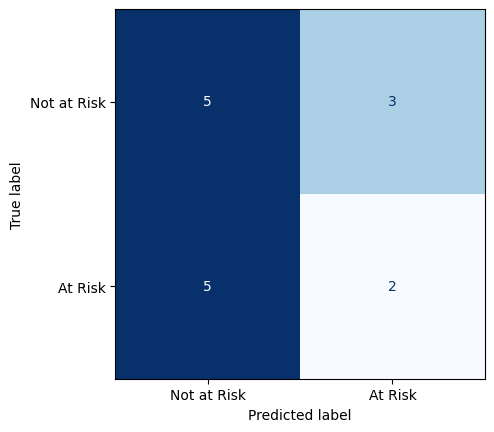

In [18]:
# Test scores
preds = grid.predict(X_test)
pred_proba = grid.predict_proba(X_test)

print (f'Accuracy: {accuracy_score(y_test, preds):.3f}')
print (f'F1 score: {f1_score(y_test, preds, average="macro"):.3f}')
print (f'AUC: {roc_auc_score(y_test, pred_proba[:,1]):.3f}')

conf_m = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay.from_predictions(y_test, preds, display_labels=["Not at Risk","At Risk"],colorbar=False, cmap=plt.cm.Blues)
plt.show()

In [19]:
print(classification_report(y_test, preds))

print (precision_recall_fscore_support(y_test, preds))

              precision    recall  f1-score   support

           0       0.50      0.62      0.56         8
           1       0.40      0.29      0.33         7

    accuracy                           0.47        15
   macro avg       0.45      0.46      0.44        15
weighted avg       0.45      0.47      0.45        15

(array([0.5, 0.4]), array([0.625     , 0.28571429]), array([0.55555556, 0.33333333]), array([8, 7], dtype=int64))


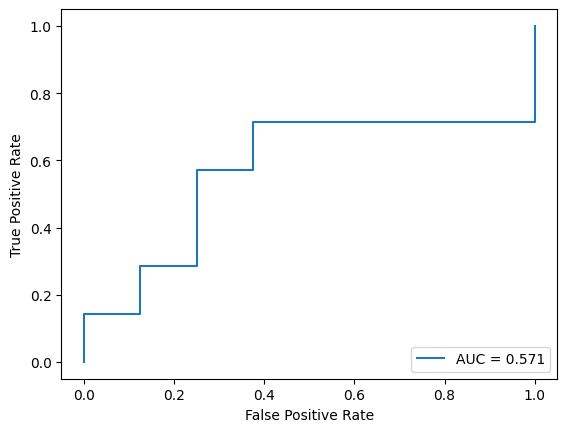

In [21]:
auc_preds = pred_proba[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  auc_preds)
auc = metrics.roc_auc_score(y_test, auc_preds)
label = f"AUC = {auc:.3f}"
plt.plot(fpr,tpr,label=label)


plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc=4)
plt.show()

## Feature Importance

[16:20:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


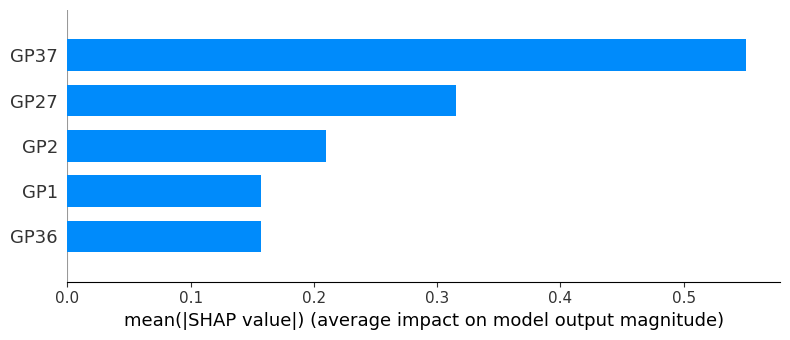

In [66]:
# Summary Plot
explainer = shap.Explainer(grid.best_estimator_['classify'], )
shap_values = explainer.shap_values(grid.best_estimator_['reduce_dim'].transform(grid.best_estimator_['scaling'].transform(X)))
shap.summary_plot(shap_values, plot_type = 'bar', feature_names=grid.best_estimator_[:-1].get_feature_names_out(), max_display=5)

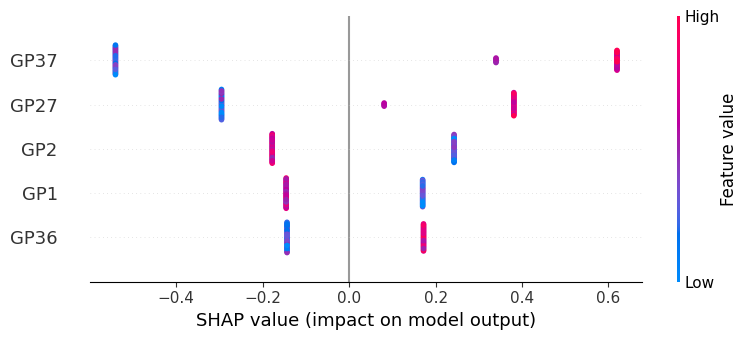

In [67]:
# Beeswarm
shap.summary_plot(shap_values, grid.best_estimator_['reduce_dim'].transform(grid.best_estimator_['scaling'].transform(X)),max_display=5,feature_names=grid.best_estimator_[:-1].get_feature_names_out())

In [68]:
shap_df = pd.DataFrame(shap_values,columns=grid.best_estimator_[:-1].get_feature_names_out())
shap_df = shap_df.replace(0.0,np.nan).dropna(how="all",axis=1)
shap_df

,GP1,GP2,GP27,GP36,GP37
0,0.170023,0.242794,0.381042,0.172115,0.619783
1,-0.145712,0.242794,0.381042,-0.143745,0.339806
2,-0.145712,-0.177955,-0.295345,0.172115,0.619783
3,-0.145712,-0.177955,0.381042,0.172115,0.619783
4,-0.145712,0.242794,-0.295345,0.172115,0.619783
...,...,...,...,...,...
69,-0.145712,0.242794,0.381042,0.172115,0.339806
70,-0.145712,-0.177955,-0.295345,-0.143745,-0.540722
71,-0.145712,-0.177955,-0.295345,-0.143745,-0.540722
72,0.170023,0.242794,0.381042,0.172115,-0.540722


## Plots

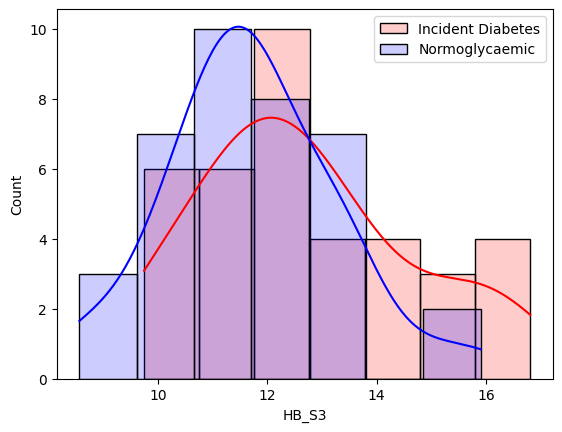

In [291]:
sns.histplot(data=df[df["DIABETES"]==1], x="HB_S3", color = "red", alpha=0.2, label="Incident Diabetes", kde=True)
sns.histplot(data=df[df["DIABETES"]==0], x="HB_S3", color = "blue", alpha=0.2, label="Normoglycaemic", kde=True)

plt.legend()
plt.show()

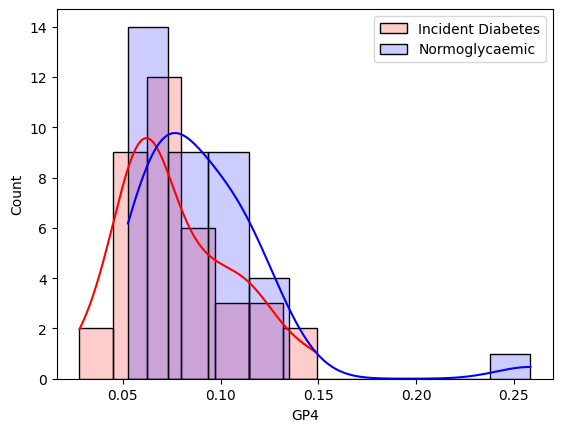

In [199]:
sns.histplot(data=df[df["DIABETES"]==1], x="GP4", color = "red", alpha=0.2, label="Incident Diabetes", kde=True)
sns.histplot(data=df[df["DIABETES"]==0], x="GP4", color = "blue", alpha=0.2, label="Normoglycaemic", kde=True)

plt.legend()
plt.show()

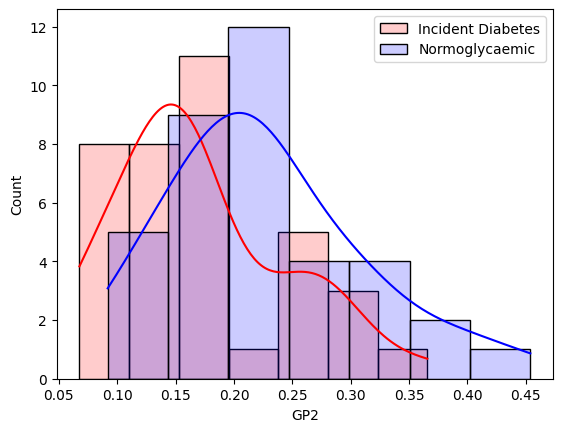

In [496]:
sns.histplot(data=df[df["DIABETES"]==1], x="GP2", color = "red", alpha=0.2, label="Incident Diabetes", kde=True)
sns.histplot(data=df[df["DIABETES"]==0], x="GP2", color = "blue", alpha=0.2, label="Normoglycaemic", kde=True)

plt.legend()
plt.show()

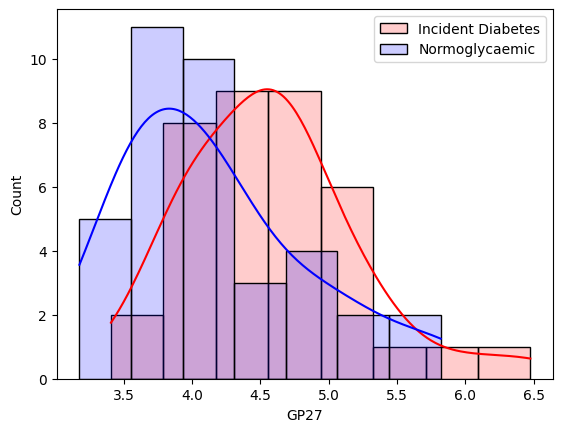

In [497]:
sns.histplot(data=df[df["DIABETES"]==1], x="GP27", color = "red", alpha=0.2, label="Incident Diabetes", kde=True)
sns.histplot(data=df[df["DIABETES"]==0], x="GP27", color = "blue", alpha=0.2, label="Normoglycaemic", kde=True)

plt.legend()
plt.show()

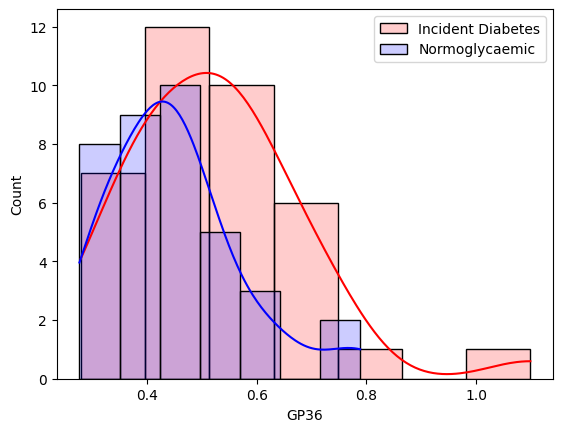

In [498]:
sns.histplot(data=df[df["DIABETES"]==1], x="GP36", color = "red", alpha=0.2, label="Incident Diabetes", kde=True)
sns.histplot(data=df[df["DIABETES"]==0], x="GP36", color = "blue", alpha=0.2, label="Normoglycaemic", kde=True)

plt.legend()
plt.show()

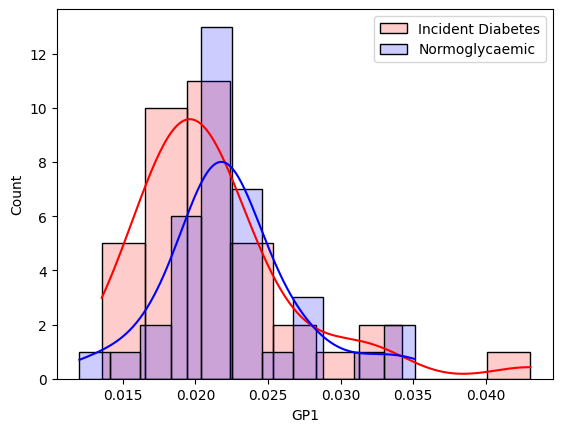

In [499]:
sns.histplot(data=df[df["DIABETES"]==1], x="GP1", color = "red", alpha=0.2, label="Incident Diabetes", kde=True)
sns.histplot(data=df[df["DIABETES"]==0], x="GP1", color = "blue", alpha=0.2, label="Normoglycaemic", kde=True)

plt.legend()
plt.show()

In [ ]:
#grid.best_estimator_['classify'].get_booster().feature_names = list(grid.best_estimator_[:-1].get_feature_names_out())
plot_tree(grid.best_estimator_['classify'])
plt.show()